# Classify Respiratory Illnesses From Audio Recordings

Fatih Catpinar <br>

### The Data is from Kaggle
https://www.kaggle.com/vbookshelf/respiratory-sound-database

Reference Noteboks:
+ https://www.kaggle.com/gizemtanriver/disease-classification-by-cnn-using-mfcc <br>
+ https://www.kaggle.com/mpotma/learndatascience-presentation-lgbm-lb-0-836 <br>
+ https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data <br>
+ https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

In [1]:
# # Note: Must install the following first in terminal first
# tensorflow
# soundfile

from os import listdir
from os.path import isfile, join
import time
import pickle

# to play an audio file
import IPython
import IPython.display as ipd 

import numpy as np
import pandas as pd

# for sound
import wave
from scipy.io import wavfile
import soundfile as sf


import tensorflow as tf
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

In [2]:
begin_start_time = time.time()

### Explore and load Data

In [3]:
# storing audio file names

# folder path for audio files
mypath = "respiratory-sound-database/" \
         "Respiratory_Sound_Database/" \
         "Respiratory_Sound_Database/audio_and_txt_files/"

# create a list of file names (only get .wav files)
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))]

# full paths of files
filepaths = [join(mypath, f) for f in filenames] 

print("Number of audio files: {}".format(len(filenames)))
print("Number of unique audio files: {}".format(len(set(filenames))))

Number of audio files: 920
Number of unique audio files: 920


In [4]:
# extracting the patient IDs

# an example of audio file name: 101_1b1_Al_sc_Meditron.wav
# first 3 digits are patient IDs

p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file)

print("Number of patient IDs: {}".format(len(p_id_in_file)))
print("Number of unique patient IDs: {}".format(len(set(p_id_in_file))))

Number of patient IDs: 920
Number of unique patient IDs: 126


In [5]:
# create the labes for the classes

# (we have the patient diagnosis csv file. In this file,
# there are two colums: patient IDs and diagnosis,
# by using the patient IDs we can create the labels for each audio file)

# patient diagnosis file path
diag_path = "respiratory-sound-database/" \
            "Respiratory_Sound_Database/" \
            "Respiratory_Sound_Database/patient_diagnosis.csv"

p_diag = pd.read_csv(diag_path, header=None)

# labels for audio files
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file])

print("Number of labels: {}".format(len(labels)))
print("Number of unique labels: {}".format(len(set(labels))))

Number of labels: 920
Number of unique labels: 8


In [6]:
# print class counts
unique_elements, counts_elements = np.unique(labels, return_counts=True)

for i in range(len(unique_elements)):
    print("{}".format(unique_elements[i]) 
          +" "*(15-len(unique_elements[i])) + ": "
          + "{}".format(counts_elements[i]))

Asthma         : 1
Bronchiectasis : 16
Bronchiolitis  : 13
COPD           : 793
Healthy        : 35
LRTI           : 2
Pneumonia      : 37
URTI           : 23


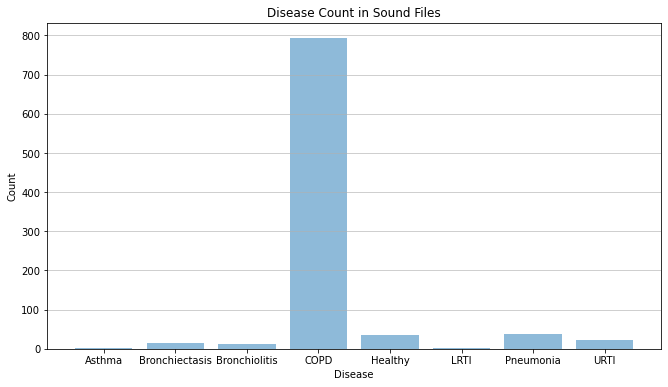

In [7]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(11,6))
plt.grid(axis='y', alpha=0.75)
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files')
plt.show()

In [8]:
# as an example: listen an audio file

# there are 920 audio files
# you can change the index number to listen a specific audio

audio_idx = np.random.randint(920) # randomly choose between 0 and 920
audio_idx = 3

print("The label index: {}".format(audio_idx))
print("The label: {}".format(labels[audio_idx]))

# play the first audio
IPython.display.display(ipd.Audio(filepaths[audio_idx]))

The label index: 3
The label: COPD


In [9]:
# we have two main element of the raw data

# Bit-depth: The amplitude of each sample in the audio.
# if it is 16, the amplitude is one of 2^16 (=65536) possible values.

# Samplig rate = Number of samples in each second
# if it is 44.1 kHz, each second in the audio consists of 44100 samples.

Data bit depth: PCM_24
Sampling (frame) rate =  44100
Total samples (frames) =  (882000,)
Duration = 20.0 seconds

The raw data of a audio file:
[ 0.00164557  0.00178432  0.00181627 ... -0.00436378 -0.00438249
 -0.00436127]


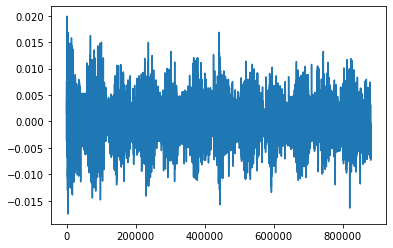

In [10]:
data, samplerate = sf.read(filepaths[audio_idx], dtype='float64')

# We have both 16bit and 24bit data, we converted the raw data to Floating point audio data
# Floating point audio data is typically in the range from -1.0 to 1.0. Integer data is in the range from -2**15 to
# 2**15-1 for 'int16' and from -2**31 to 2**31-1 for 'int32'.

file = sf.SoundFile(filepaths[audio_idx])
print("Data bit depth: {}".format(file.subtype))

print("Sampling (frame) rate = ", samplerate)
print("Total samples (frames) = ", data.shape)

print("Duration = {} seconds".format(data.shape[0] / samplerate))

print("\nThe raw data of a audio file:")
print(data)

# plot the data
plt.plot(data, '-', )
plt.show()

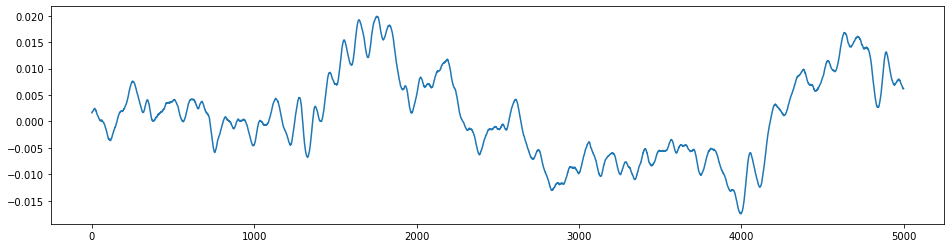

In [11]:
# first 5000 data points

plt.figure(figsize=(16, 4))
plt.plot(data[:5000], '-')
plt.show()

In [12]:
# Note that we could use wavfile.read to read the raw data
# which return the sample rate (in samples/sec) and data from a WAV file
# But this function cannot read wav files with 24-bit data.
# asmentioned before we have 24-bit data as well

In [13]:
# Iterate through each sound file and load the raw data

start_time = time.time()

data_all = []
samplerate_all = []
lengths_sec = []
lengths_n_data_points = []
for file_name in filepaths:
    data, samplerate = sf.read(file_name, dtype='float64')
    data_all.append(data)
    samplerate_all.append(samplerate)
    lengths_sec.append(len(data)/samplerate) # in seconds
    lengths_n_data_points.append(len(data))
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.285209894180298 seconds ---


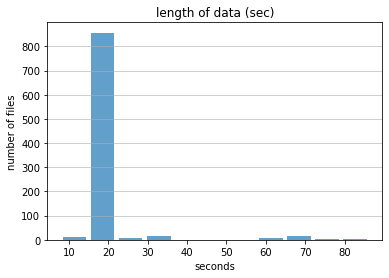

In [14]:
plt.hist(lengths_sec, bins = 'auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('seconds')
plt.ylabel('number of files')
plt.title('length of data (sec)')
plt.show()

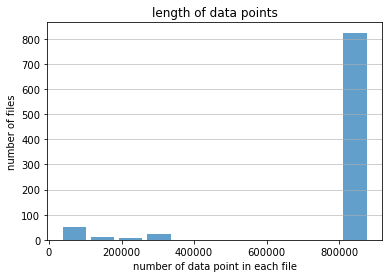

In [15]:
plt.hist(lengths_n_data_points, bins = 'auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('number of data point in each file')
plt.ylabel('number of files')
plt.title('length of data points')
plt.show()

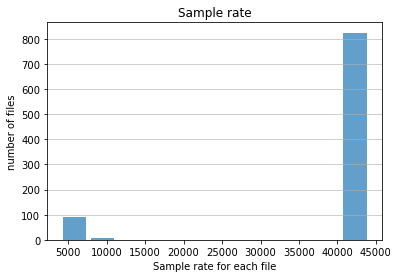

In [16]:
plt.hist(samplerate_all, bins = 'auto', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Sample rate for each file')
plt.ylabel('number of files')
plt.title('Sample rate')
plt.show()

In [17]:
# Files length are between 10 sec and 90 sec, majority of the audio files are 20 sec.
# and mojority of them are 44.1 khz

In [18]:
# normalize between 0 and 1
def normalize(data):
    max_data = np.max(data)
    min_data = np.min(data)
    eps = 1e-10 # added epsilons in case divide by zero error.
    data = (data-min_data)/(max_data-min_data+eps)
    return data

In [19]:
def standardize(data):
    data_mean = np.mean(data)
    data_std = np.std(data, ddof=1)
    eps = 1e-10 # added epsilons in case divide by zero error.
    data = (data - data_mean+eps) / (data_std+eps)
    return data

In [20]:
# padding
def pad(data,input_length,pad_constant):
    if len(data) > input_length:
        max_offset = len(data) - input_length
        offset = np.random.randint(max_offset)
        data = data[offset:(input_length+offset)]
    else:
        if input_length > len(data):
            max_offset = input_length - len(data)
            offset = np.random.randint(max_offset)
        else:
            offset = 0
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant", constant_values=pad_constant)      
    return data

In [21]:
# using 5 seconds of data now, will change later

input_length = 44100*5
pad_constant= 0
data_padded = np.zeros([len(data_all),input_length,1])
for i in range(len(data_all)):
    data = pad(data_all[i],input_length,pad_constant)
    data_padded[i] = data.reshape(len(data),1)
    
print(data_padded.shape)

(920, 220500, 1)


### More pre-processing

In [22]:
# one class outnumber the others by a large proportion.
# as seen the imbalanced ruined the model

# to do:
# delete the rare clases
# split with same distrubution
# apply SMOTE to take care imbalanced data

/Users/fatih/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


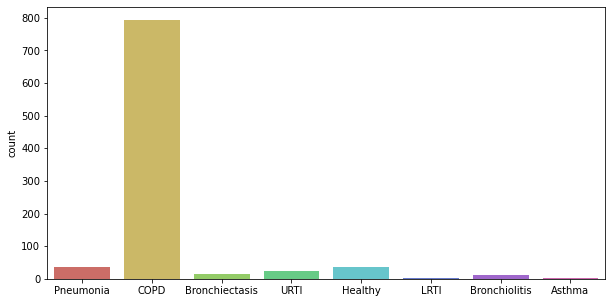

In [23]:
plt.figure(figsize=(10,5))
sns.countplot(labels, palette='hls')
plt.show()

In [24]:
# deleting the very rare diseases: 'Asthma' and 'LRTI'

data_padded = np.delete(data_padded, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 
labels = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

print(data_padded.shape)
print(labels.shape)

(917, 220500, 1)
(917,)


/Users/fatih/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


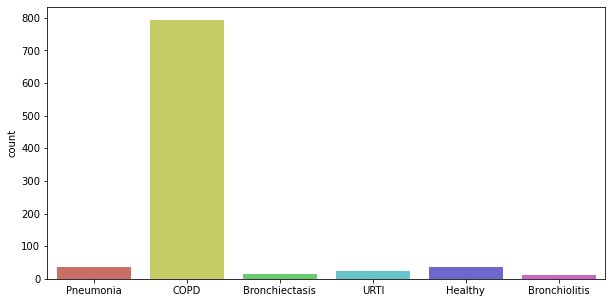

In [25]:
# after deleting rare diseases

plt.figure(figsize=(10,5))
sns.countplot(labels, palette='hls')
plt.show()

### Split data

In [26]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(data_padded, labels, test_size=0.2, random_state=0, stratify=labels)

In [27]:
# making sure the test and train disturbition is same for all classes
(unique, counts) = np.unique(y_train, axis=0, return_counts=True)

for i in range(len(unique)):
    print(unique[i], counts[i], counts[i]/np.sum(counts))

Bronchiectasis 13 0.017735334242837655
Bronchiolitis 10 0.013642564802182811
COPD 634 0.8649386084583902
Healthy 28 0.03819918144611187
Pneumonia 30 0.040927694406548434
URTI 18 0.02455661664392906


In [28]:
(unique, counts) = np.unique(y_test, axis=0, return_counts=True)
for i in range(len(unique)):
    print(unique[i], counts[i], counts[i]/np.sum(counts))

Bronchiectasis 3 0.016304347826086956
Bronchiolitis 3 0.016304347826086956
COPD 159 0.8641304347826086
Healthy 7 0.03804347826086957
Pneumonia 7 0.03804347826086957
URTI 5 0.02717391304347826


In [29]:
# SMOTE train data

start_time = time.time()

# reshape (smote does not accept 3 dim)
print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1])
print(x_train.shape)

# smote 
os = SMOTE(random_state=0)
x_train, y_train = os.fit_sample(x_train, y_train)

# reshape back
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print(x_train.shape)

print("--- %s seconds ---" % (time.time() - start_time))

(733, 220500, 1)
(733, 220500)
(3804, 220500, 1)
--- 49.048460960388184 seconds ---


In [30]:
import sklearn
sklearn.__version__


'0.23.1'

In [31]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3804, 220500, 1)
(3804,)
(184, 220500, 1)
(184,)


In [32]:
# shuffle after SMOTE

train_idx = list(range(len(x_train)))
np.random.shuffle(train_idx)

test_idx = list(range(len(x_test)))
np.random.shuffle(test_idx)

x_train = x_train[train_idx]
y_train = y_train[train_idx]
x_test = x_test[test_idx]
y_test = y_test[test_idx]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3804, 220500, 1)
(3804,)
(184, 220500, 1)
(184,)


/Users/fatih/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


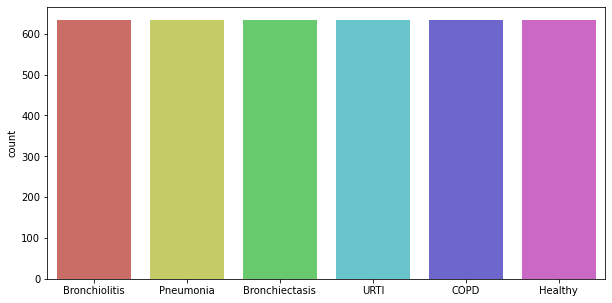

In [33]:
# train data after SMOTE

plt.figure(figsize=(10,5))
sns.countplot(y_train, palette='hls')
plt.show()

In [34]:
# one-hot encode train labels

# transform non-numerical labels to numerical labels
le_train = LabelEncoder()
y_train_encoded = le_train.fit_transform(y_train) 

# Converts a class vector (integers) to binary class matrix.
y_train_onehot = tf.keras.utils.to_categorical(y_train_encoded) 


# one-hot encode test labels

# transform non-numerical labels to numerical labels
le_test = LabelEncoder()
y_test_encoded = le_test.fit_transform(y_test) 

# Converts a class vector (integers) to binary class matrix.
y_test_onehot = tf.keras.utils.to_categorical(y_test_encoded) 

In [35]:
print(x_train.shape)
print(y_train_onehot.shape)
print(x_test.shape)
print(y_test_onehot.shape)

(3804, 220500, 1)
(3804, 6)
(184, 220500, 1)
(184, 6)


# Spectrograms
"Deep learning models rarely take this raw audio directly as input. The common practice is to convert the audio into a spectrogram. The spectrogram is a concise ‘snapshot’ of an audio wave and since it is an image, it is well suited to being input to CNN-based architectures developed for handling images.
Spectrograms are generated from sound signals using Fourier Transforms. A Fourier Transform decomposes the signal into its constituent frequencies and displays the amplitude of each frequency present in the signal.
A Spectrogram chops up the duration of the sound signal into smaller time segments and then applies the Fourier Transform to each segment, to determine the frequencies contained in that segment. It then combines the Fourier Transforms for all those segments into a single plot.
It plots Frequency (y-axis) vs Time (x-axis) and uses different colors to indicate the Amplitude of each frequency. The brighter the color the higher the energy of the signal."

This paragraph is from: https://towardsdatascience.com/audio-deep-learning-made-simple-part-2-why-mel-spectrograms-perform-better-aad889a93505

In [43]:
# Mel Scale

### Model

In [36]:
# model = Sequential()

# n_features = x_train.shape[2] 
# n_timesteps = x_train.shape[1]
# n_outputs = y_train_onehot.shape[1]

# model.add(tf.keras.layers.Conv1D(filters=2, kernel_size=100, activation='relu', input_shape=(n_timesteps,n_features)))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=10))
# model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=100, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=10))
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(100, activation='relu'))
# model.add(tf.keras.layers.Dense(n_outputs, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Display model architecture summary 
# model.summary()

In [37]:
# # Calculate pre-training accuracy 
# score = model.evaluate(x_test, y_test_onehot, verbose=1)
# accuracy = 100*score[1]

# print("Pre-training accuracy: %.4f%%" % accuracy)

# # trianing
# model.fit(x_train, y_train_onehot, epochs=7, batch_size=32, verbose=1)

# # Calculate post-training accuracy 
# score = model.evaluate(x_test, y_test_onehot, verbose=1)
# accuracy = 100*score[1]

# print("Post-training accuracy: %.4f%%" % accuracy)

In [38]:
# y_test_hat = model.predict_classes(x_test)

In [39]:
# # pritn first 3 prediction and true class

# for i in range(3):
#     print("Predicted Class: {}, True Class: {}".format(y_test_hat[i], y_test_onehot[i]) )

In [40]:
# y_test_decoded = tf.argmax(y_test_onehot, axis=1)

In [41]:
# CM = tf.math.confusion_matrix(y_test_decoded, y_test_hat)
# CM = np.array(CM)
# CM

In [42]:
# df_cm = pd.DataFrame(CM, index = [i for i in unique],
#                   columns = [i for i in unique])

# plt.figure(figsize = (10,7))
# sns.heatmap(df_cm, annot=True, fmt="d")
# plt.show()